**Mounting Google-Drive:** 

First of all we must mount our drive
Code is from:
https://colab.research.google.com/drive/1KnkVuYW6Ne25hOZ_IApiv_MIYb4lxCAq?usp=sharing


Full tutorial is at: 
https://towardsdatascience.com/fine-tuning-transformer-model-for-invoice-recognition-1e55869336d4

Also downloaded to computer search for the text in the url above.

ZP Note to self: created the training data by parsing the Astrobee files and uploading them to UBIAI (use my normal gmail to login). In the annotation workscreen there is a download option. Select Download-->OCR format-->OCR processed form. You'll get a zip which has text files. They need to be duplicated. Name one copy test.txt and another copy train.txt. Do the same with the test_boxes / train_boxes or somethign like that. See the files in "C:\Users\User1\Downloads\NASA Risk Export GOOD Labels Bounding Boxes Annotated 2021-12-11" for examples. You need to look at text files to understand the contents.

ZP Follow up:
1. The original code below uses a token classification model; what is really needed is a sequence classification model (LayoutLMForSequenceClassification; see the Huggingface docs for LayoutLM) but the code below as is will probably still work crudely to help start the process of getting risk data into a workable format for a somewhat fast human-in-the-loop historical risk extraction process.
2. Save all gits and libraries used maybe just in case.
3. Export the model after trained and use in a publicly avaialable PoC webapp that can accept any image (or maybe DOC) upload 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**Install libraries:**


In [ ]:
! rm -r unilm
! git clone -b remove_torch_save https://github.com/NielsRogge/unilm.git
! cd unilm/layoutlm
! pip install unilm/layoutlm

rm: cannot remove 'unilm': No such file or directory
Cloning into 'unilm'...
remote: Enumerating objects: 3687, done.
remote: Total 3687 (delta 0), reused 0 (delta 0), pack-reused 3687
Receiving objects: 100% (3687/3687), 6.43 MiB | 12.29 MiB/s, done.
Resolving deltas: 100% (1575/1575), done.
Processing ./unilm/layoutlm
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
     |████████████████████████████████| 635 kB 4.3 MB/s 
     |████████████████████████████████| 195 kB 45.3 MB/s 
     |████████████████████████████████| 5.5 MB 22.7 MB/s 
     |████████████████████████████████| 5.6 MB 36.6 MB/s 
     |████████████████████████████████| 895 kB 45.5

In [ ]:
! rm -r transformers
! git clone https://github.com/huggingface/transformers.git
! cd transformers
! pip install ./transformers

rm: cannot remove 'transformers': No such file or directory
Cloning into 'transformers'...
remote: Enumerating objects: 96109, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 96109 (delta 12), reused 23 (delta 11), pack-reused 96082
Receiving objects: 100% (96109/96109), 81.12 MiB | 14.14 MiB/s, done.
Resolving deltas: 100% (69750/69750), done.
Processing ./transformers
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████

In [ ]:
from torch.nn import CrossEntropyLoss

def get_labels(path):
    with open(path, "r") as f:
        labels = f.read().splitlines()
    if "O" not in labels:
        labels = ["O"] + labels
    return labels

labels = get_labels("/content/drive/MyDrive/UBIAI_layoutlm/data_blue_nine/labels.txt")
num_labels = len(labels)
label_map = {i: label for i, label in enumerate(labels)}
# Use cross entropy ignore index as padding label id so that only real label ids contribute to the loss later
pad_token_label_id = CrossEntropyLoss().ignore_index

In [ ]:
from transformers import LayoutLMTokenizer
from layoutlm.data.funsd import FunsdDataset, InputFeatures
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

args = {'local_rank': -1,
        'overwrite_cache': True,
        'data_dir': '/content/drive/MyDrive/UBIAI_layoutlm/data_blue_nine/',
        'model_name_or_path':'microsoft/layoutlm-base-uncased',
        'max_seq_length': 512,
        'model_type': 'layoutlm',}

# class to turn the keys of a dict into attributes (thanks Stackoverflow)
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self

args = AttrDict(args)

tokenizer = LayoutLMTokenizer.from_pretrained("microsoft/layoutlm-base-uncased")

# the LayoutLM authors already defined a specific FunsdDataset, so we are going to use this here
train_dataset = FunsdDataset(args, tokenizer, labels, pad_token_label_id, mode="train")
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset,
                              sampler=train_sampler,
                              batch_size=2)

eval_dataset = FunsdDataset(args, tokenizer, labels, pad_token_label_id, mode="test")
eval_sampler = SequentialSampler(eval_dataset)
eval_dataloader = DataLoader(eval_dataset,
                             sampler=eval_sampler,
                            batch_size=2)



Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/170 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/606 [00:00<?, ?B/s]

In [ ]:
batch = next(iter(train_dataloader))
input_ids = batch[0][0]
tokenizer.decode(input_ids)

'[CLS] game changing development program human exploration telerobotics 2 ( het2 ) document no. : gcdp - 02 - pln - 14080 revision : b gcd project plan document date : 12 / 21 / 2016 page 16 of 45 perching arm : near - flight design with a perching arm assembly. control stations : the operator ui, iss models, commanding and monitoring. this will also include minimal rapid / dds protocols. prototype 4 will focus on the flight - like hardware design. structure : flight like design, 3d printed, no " paint job ". propulsion : flight propulsion modules. c & dh : flight avionics stack. gn & c : flight imu and software. flight software ( fsw ) : minimal software to enable testing of all hardware - related requirements. thermal : active thermal control. docking : full dock to include the iss interface. non - flight like dock. control stations : planning module / plan editor for the operator control station. the certification units will be developed off the final prototype 4 design, with any mo

In [ ]:
from transformers import LayoutLMForTokenClassification
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LayoutLMForTokenClassification.from_pretrained("microsoft/layoutlm-base-uncased", num_labels=num_labels)
model.to(device)

Downloading:   0%|          | 0.00/432M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/layoutlm-base-uncased were not used when initializing LayoutLMForTokenClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LayoutLMForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LayoutLMForTokenClassification were not initialized from the model checkpoint at microsoft

LayoutLMForTokenClassification(
  (layoutlm): LayoutLMModel(
    (embeddings): LayoutLMEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (x_position_embeddings): Embedding(1024, 768)
      (y_position_embeddings): Embedding(1024, 768)
      (h_position_embeddings): Embedding(1024, 768)
      (w_position_embeddings): Embedding(1024, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): LayoutLMEncoder(
      (layer): ModuleList(
        (0): LayoutLMLayer(
          (attention): LayoutLMAttention(
            (self): LayoutLMSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
         

In [ ]:

from transformers import LayoutLMTokenizer
from layoutlm.data.funsd import FunsdDataset, InputFeatures
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler


tokenizer = LayoutLMTokenizer.from_pretrained("microsoft/layoutlm-base-uncased")

**Start Training**

In [ ]:
from transformers import AdamW
from tqdm import tqdm

optimizer = AdamW(model.parameters(), lr=5e-5)

global_step = 0
num_train_epochs = 15
t_total = len(train_dataloader) * num_train_epochs # total number of training steps 

#put the model in training mode
model.train()
for epoch in range(num_train_epochs):
  for batch in tqdm(train_dataloader, desc="Training"):
      input_ids = batch[0].to(device)
      bbox = batch[4].to(device)
      attention_mask = batch[1].to(device)
      token_type_ids = batch[2].to(device)
      labels = batch[3].to(device)

      # forward pass
      outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids,
                      labels=labels)
      loss = outputs.loss

      # print loss every 100 steps
      if global_step % 100 == 0:
        print(f"Loss after {global_step} steps: {loss.item()}")

      # backward pass to get the gradients 
      loss.backward()

      #print("Gradients on classification head:")
      #print(model.classifier.weight.grad[6,:].sum())

      # update
      optimizer.step()
      optimizer.zero_grad()
      global_step += 1

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
Training:   0%|          | 0/4 [00:00<?, ?it/s]

Loss after 0 steps: 2.6780447959899902


Training: 100%|██████████| 4/4 [00:01<00:00,  2.61it/s]


## Evaluation

Now let's evaluate on the test set:

In [ ]:
import numpy as np
from seqeval.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score,
)

eval_loss = 0.0
nb_eval_steps = 0
preds = None
out_label_ids = None

# put model in evaluation mode
model.eval()
for batch in tqdm(eval_dataloader, desc="Evaluating"):
    with torch.no_grad():
        input_ids = batch[0].to(device)
        bbox = batch[4].to(device)
        attention_mask = batch[1].to(device)
        token_type_ids = batch[2].to(device)
        labels = batch[3].to(device)

        # forward pass
        outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids,
                        labels=labels)
        # get the loss and logits
        tmp_eval_loss = outputs.loss
        logits = outputs.logits

        eval_loss += tmp_eval_loss.item()
        nb_eval_steps += 1

        # compute the predictions
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = labels.detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(
                out_label_ids, labels.detach().cpu().numpy(), axis=0
            )

# compute average evaluation loss
eval_loss = eval_loss / nb_eval_steps
preds = np.argmax(preds, axis=2)

out_label_list = [[] for _ in range(out_label_ids.shape[0])]
preds_list = [[] for _ in range(out_label_ids.shape[0])]

for i in range(out_label_ids.shape[0]):
    for j in range(out_label_ids.shape[1]):
        if out_label_ids[i, j] != pad_token_label_id:
            out_label_list[i].append(label_map[out_label_ids[i][j]])
            preds_list[i].append(label_map[preds[i][j]])

results = {
    "loss": eval_loss,
    "precision": precision_score(out_label_list, preds_list),
    "recall": recall_score(out_label_list, preds_list),
    "f1": f1_score(out_label_list, preds_list),
}
print(results)

Evaluating: 100%|██████████| 4/4 [00:00<00:00,  6.96it/s]

{'loss': 0.2390750024933368, 'precision': 0.696969696969697, 'recall': 0.5111111111111111, 'f1': 0.5897435897435898}


In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 37 not upgraded.
Need to get 4,795 kB of archives.
After this operation, 15.8 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-eng all 4.00~git24-0e00fe6-1.2 [1,588 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr-osd all 4.00~git24-0e00fe6-1.2 [2,989 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tesseract-ocr amd64 4.00~git2288-10f4998a-2 [218 kB]
Fetched 4,795 kB in 3s (1,538 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl

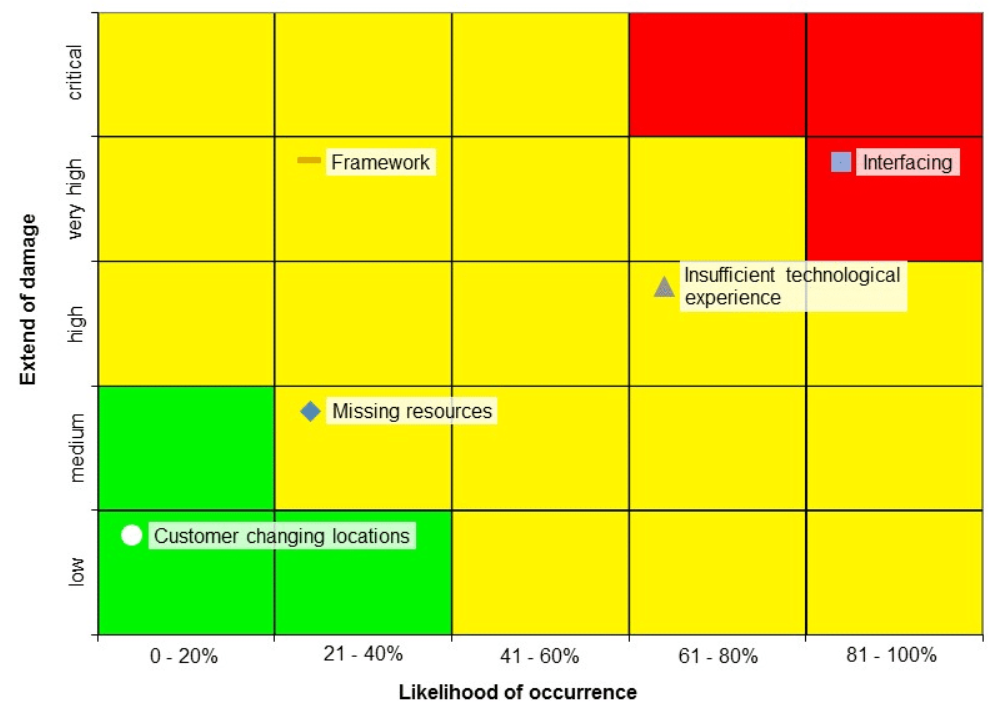

In [ ]:
import pytesseract
from PIL import Image, ImageDraw, ImageFont

#image = Image.open('/content/form_example.jpg')
image = Image.open("/content/drive/MyDrive/inferenceNASAtest2.jpg")
image = image.convert("RGB")
image

In [ ]:
import numpy as np

width, height = image.size
w_scale = 1000/width
h_scale = 1000/height

ocr_df = pytesseract.image_to_data(image, output_type='data.frame') \
            
ocr_df = ocr_df.dropna() \
               .assign(left_scaled = ocr_df.left*w_scale,
                       width_scaled = ocr_df.width*w_scale,
                       top_scaled = ocr_df.top*h_scale,
                       height_scaled = ocr_df.height*h_scale,
                       right_scaled = lambda x: x.left_scaled + x.width_scaled,
                       bottom_scaled = lambda x: x.top_scaled + x.height_scaled)

float_cols = ocr_df.select_dtypes('float').columns
ocr_df[float_cols] = ocr_df[float_cols].round(0).astype(int)
ocr_df = ocr_df.replace(r'^\s*$', np.nan, regex=True)
ocr_df = ocr_df.dropna().reset_index(drop=True)
ocr_df[:20]

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text,left_scaled,width_scaled,top_scaled,height_scaled,right_scaled,bottom_scaled
0,5,1,1,1,1,1,20,319,15,65,96,Extend,20,15,448,91,35,539
1,5,1,1,1,1,2,20,293,15,19,95,of,20,15,412,27,35,438
2,5,1,1,1,1,3,20,214,19,74,96,damage,20,19,301,104,39,404
3,5,1,2,1,1,1,69,414,15,68,93,medium,69,15,581,96,84,677
4,5,1,2,1,1,2,67,307,19,35,96,high,67,19,431,49,86,480
5,5,1,2,1,1,3,70,204,15,35,92,very,70,15,287,49,85,336
6,5,1,2,1,1,4,66,159,19,35,96,high,66,19,223,49,85,272
7,5,1,2,1,1,5,66,46,15,54,96,critical,66,15,65,76,81,140
8,5,1,3,1,1,1,69,558,15,28,96,low,69,15,784,39,84,823
9,5,1,5,1,1,1,333,154,96,15,96,Framework,334,96,216,21,431,237


In [ ]:
len(ocr_df)

37

In [ ]:
words = list(ocr_df.text)
coordinates = ocr_df[['left', 'top', 'width', 'height']]
actual_boxes = []
for idx, row in coordinates.iterrows():
  x, y, w, h = tuple(row) # the row comes in (left, top, width, height) format
  actual_box = [x, y, x+w, y+h] # we turn it into (left, top, left+widght, top+height) to get the actual box 
  actual_boxes.append(actual_box)

def normalize_box(box, width, height):
    return [
        int(1000 * (box[0] / width)),
        int(1000 * (box[1] / height)),
        int(1000 * (box[2] / width)),
        int(1000 * (box[3] / height)),
    ]

boxes = []
for box in actual_boxes:
  boxes.append(normalize_box(box, width, height))
boxes

[[20, 448, 35, 539],
 [20, 411, 35, 438],
 [20, 300, 39, 404],
 [69, 581, 84, 676],
 [67, 431, 86, 480],
 [70, 286, 85, 335],
 [66, 223, 85, 272],
 [66, 64, 81, 140],
 [69, 783, 84, 823],
 [334, 216, 430, 237],
 [688, 411, 783, 432],
 [688, 375, 778, 396],
 [789, 375, 902, 401],
 [302, 564, 321, 591],
 [335, 566, 400, 592],
 [408, 571, 492, 587],
 [0, 0, 1000, 1000],
 [121, 737, 142, 765],
 [155, 741, 239, 762],
 [247, 741, 325, 768],
 [334, 741, 410, 762],
 [151, 910, 172, 931],
 [179, 910, 217, 931],
 [326, 905, 343, 928],
 [353, 919, 357, 922],
 [366, 905, 403, 928],
 [503, 910, 521, 931],
 [530, 924, 535, 925],
 [543, 910, 581, 931],
 [681, 910, 700, 931],
 [709, 924, 714, 925],
 [722, 910, 761, 931],
 [401, 960, 498, 981],
 [507, 960, 525, 981],
 [532, 966, 639, 981],
 [863, 908, 882, 929],
 [892, 908, 939, 929]]

In [ ]:
def convert_example_to_features(image, words, boxes, actual_boxes, tokenizer, args, cls_token_box=[0, 0, 0, 0],
                                 sep_token_box=[1000, 1000, 1000, 1000],
                                 pad_token_box=[0, 0, 0, 0]):
      width, height = image.size

      tokens = []
      token_boxes = []
      actual_bboxes = [] # we use an extra b because actual_boxes is already used
      token_actual_boxes = []
      for word, box, actual_bbox in zip(words, boxes, actual_boxes):
          word_tokens = tokenizer.tokenize(word)
          tokens.extend(word_tokens)
          token_boxes.extend([box] * len(word_tokens))
          actual_bboxes.extend([actual_bbox] * len(word_tokens))
          token_actual_boxes.extend([actual_bbox] * len(word_tokens))

      # Truncation: account for [CLS] and [SEP] with "- 2". 
      special_tokens_count = 2 
      if len(tokens) > args.max_seq_length - special_tokens_count:
          tokens = tokens[: (args.max_seq_length - special_tokens_count)]
          token_boxes = token_boxes[: (args.max_seq_length - special_tokens_count)]
          actual_bboxes = actual_bboxes[: (args.max_seq_length - special_tokens_count)]
          token_actual_boxes = token_actual_boxes[: (args.max_seq_length - special_tokens_count)]

      # add [SEP] token, with corresponding token boxes and actual boxes
      tokens += [tokenizer.sep_token]
      token_boxes += [sep_token_box]
      actual_bboxes += [[0, 0, width, height]]
      token_actual_boxes += [[0, 0, width, height]]
      
      segment_ids = [0] * len(tokens)

      # next: [CLS] token
      tokens = [tokenizer.cls_token] + tokens
      token_boxes = [cls_token_box] + token_boxes
      actual_bboxes = [[0, 0, width, height]] + actual_bboxes
      token_actual_boxes = [[0, 0, width, height]] + token_actual_boxes
      segment_ids = [1] + segment_ids

      input_ids = tokenizer.convert_tokens_to_ids(tokens)

      # The mask has 1 for real tokens and 0 for padding tokens. Only real
      # tokens are attended to.
      input_mask = [1] * len(input_ids)

      # Zero-pad up to the sequence length.
      padding_length = args.max_seq_length - len(input_ids)
      input_ids += [tokenizer.pad_token_id] * padding_length
      input_mask += [0] * padding_length
      segment_ids += [tokenizer.pad_token_id] * padding_length
      token_boxes += [pad_token_box] * padding_length
      token_actual_boxes += [pad_token_box] * padding_length

      assert len(input_ids) == args.max_seq_length
      assert len(input_mask) == args.max_seq_length
      assert len(segment_ids) == args.max_seq_length
      #assert len(label_ids) == args.max_seq_length
      assert len(token_boxes) == args.max_seq_length
      assert len(token_actual_boxes) == args.max_seq_length
      
      return input_ids, input_mask, segment_ids, token_boxes, token_actual_boxes

In [ ]:
input_ids, input_mask, segment_ids, token_boxes, token_actual_boxes = convert_example_to_features(image=image, words=words, boxes=boxes, actual_boxes=actual_boxes, tokenizer=tokenizer, args=args)

In [ ]:
tokenizer.decode(input_ids)

'[CLS] extend of damage medium high very high critical low framework experience insufficient technological ® missing resources ( ) customer changing locations 0 - 20 % 21 - 40 % 41 - 60 % 61 - 80 % likelihood of occurrence 1 - 100 % [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

In [ ]:
input_ids = torch.tensor(input_ids, device=device).unsqueeze(0)
input_ids.shape

torch.Size([1, 512])

In [ ]:
attention_mask = torch.tensor(input_mask, device=device).unsqueeze(0)
attention_mask.shape

torch.Size([1, 512])

In [ ]:
token_type_ids = torch.tensor(segment_ids, device=device).unsqueeze(0)
token_type_ids.shape

torch.Size([1, 512])

In [ ]:
bbox = torch.tensor(token_boxes, device=device).unsqueeze(0)
bbox.shape

torch.Size([1, 512, 4])

In [ ]:
outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids)
outputs

TokenClassifierOutput([('logits',
                        tensor([[[-0.0638, -0.3087, -0.4514,  ...,  0.8970, -0.0508,  0.1037],
                                 [ 0.2577, -0.0177,  0.2179,  ...,  0.4517, -0.2679, -0.1986],
                                 [-0.0335, -0.8246, -0.0719,  ..., -0.3867, -1.2165, -0.0932],
                                 ...,
                                 [ 0.8491, -0.9617, -0.2435,  ..., -0.3098, -0.5566, -0.1299],
                                 [ 0.5681, -0.9919, -0.2240,  ..., -0.4198, -0.3191, -0.3040],
                                 [ 0.1112, -1.1195,  0.2452,  ..., -0.4841, -0.4739, -0.8354]]],
                               device='cuda:0', grad_fn=<AddBackward0>))])

In [ ]:
outputs.logits.shape
print(outputs.logits)

tensor([[[-0.0638, -0.3087, -0.4514,  ...,  0.8970, -0.0508,  0.1037],
         [ 0.2577, -0.0177,  0.2179,  ...,  0.4517, -0.2679, -0.1986],
         [-0.0335, -0.8246, -0.0719,  ..., -0.3867, -1.2165, -0.0932],
         ...,
         [ 0.8491, -0.9617, -0.2435,  ..., -0.3098, -0.5566, -0.1299],
         [ 0.5681, -0.9919, -0.2240,  ..., -0.4198, -0.3191, -0.3040],
         [ 0.1112, -1.1195,  0.2452,  ..., -0.4841, -0.4739, -0.8354]]],
       device='cuda:0', grad_fn=<AddBackward0>)


In [ ]:
outputs.logits.argmax(-1)
print(outputs)

TokenClassifierOutput(loss=None, logits=tensor([[[-0.0638, -0.3087, -0.4514,  ...,  0.8970, -0.0508,  0.1037],
         [ 0.2577, -0.0177,  0.2179,  ...,  0.4517, -0.2679, -0.1986],
         [-0.0335, -0.8246, -0.0719,  ..., -0.3867, -1.2165, -0.0932],
         ...,
         [ 0.8491, -0.9617, -0.2435,  ..., -0.3098, -0.5566, -0.1299],
         [ 0.5681, -0.9919, -0.2240,  ..., -0.4198, -0.3191, -0.3040],
         [ 0.1112, -1.1195,  0.2452,  ..., -0.4841, -0.4739, -0.8354]]],
       device='cuda:0', grad_fn=<AddBackward0>), hidden_states=None, attentions=None)


In [ ]:
token_predictions = outputs.logits.argmax(-1).squeeze().tolist() # the predictions are at the token level
print(token_predictions)

word_level_predictions = [] # let's turn them into word level predictions
final_boxes = []
for id, token_pred, box in zip(input_ids.squeeze().tolist(), token_predictions, token_actual_boxes):
  if (tokenizer.decode([id]).startswith("##")) or (id in [tokenizer.cls_token_id, 
                                                           tokenizer.sep_token_id, 
                                                          tokenizer.pad_token_id]):
    # skip prediction + bounding box

    continue
  else:
    word_level_predictions.append(token_pred)
    final_boxes.append(box)

# for id, prediction in zip(input_ids.squeeze().tolist(), predictions):
#   if id != 0:
#     print(tokenizer.decode([id]), label_map[prediction])
print(word_level_predictions)

[11, 9, 9, 9, 9, 9, 9, 9, 9, 9, 5, 5, 2, 8, 9, 2, 5, 9, 9, 2, 8, 5, 0, 9, 3, 9, 0, 9, 3, 9, 0, 9, 3, 9, 0, 9, 3, 9, 9, 9, 9, 0, 9, 3, 9, 11, 0, 9, 9, 9, 0, 0, 9, 9, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 9, 0, 9, 9, 9, 9, 9, 9, 9, 9, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 9, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 9, 9, 9, 9, 9, 9, 9, 9, 0, 0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 0, 9, 9, 9, 0, 9, 0, 0, 0

In [ ]:
print(len(word_level_predictions))

44


In [ ]:
print(len(final_boxes))

44


O
Extend
O
of
O
damage
O
medium
O
high
O
very
O
high
O
critical
O
low
E-RISKUID
Frameworkriskuid
E-RISKUID
experienceriskuid
B-RISKUID
Insufficientriskuid
I-RISKUID
technologicalriskuid
O
®
B-RISKUID
Missingriskuid
E-RISKUID
resourcesriskuid
O
(
O
)
B-RISKUID
Customerriskuid
I-RISKUID
changingriskuid
E-RISKUID
locationsriskuid
B-LIKELIHOOD
0-likelihood
O
20%
E-LIKELIHOOD
21likelihood
O
-
B-LIKELIHOOD
40%likelihood
O
41
E-LIKELIHOOD
-likelihood
O
60%
B-LIKELIHOOD
61likelihood
O
-
E-LIKELIHOOD
80%likelihood
O
Likelihood
B-LIKELIHOOD
oflikelihood
O
occurrence
E-LIKELIHOOD
1-likelihood
O
100%


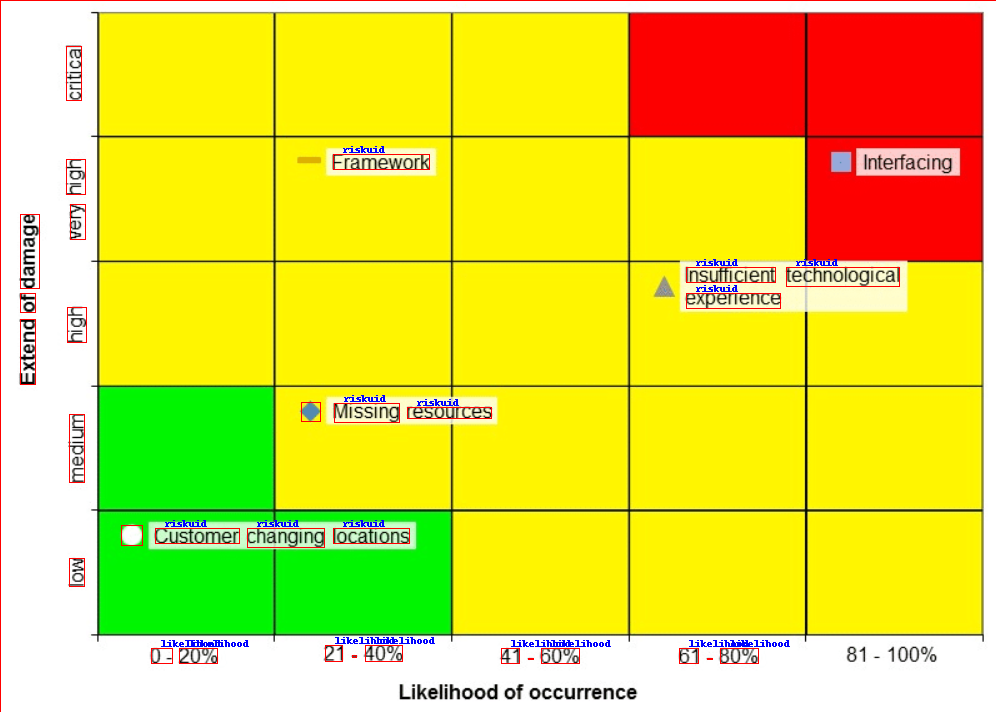

In [ ]:
draw = ImageDraw.Draw(image)

font = ImageFont.load_default()

def iob_to_label(label):
  if label != 'O':
    return label[2:]
  else:
    return ""

label2color = {'question':'blue', 'B-RISKUID':'green', 'I-RISKUID':'orange', 'other':'violet'}

for prediction, box, word in zip(word_level_predictions, final_boxes ,words):
#for prediction, box in zip(word_level_predictions, final_boxes):
    predicted_label = iob_to_label(label_map[prediction]).lower()
    
    #ZP Adding this to try to get Beginning Middle and End of entities
    predicted_label_ZP = iob_to_label(label_map[prediction])
    
    
    
    #print(word_level_predictions)
    #print(label_map[prediction])
    #print(predicted_label)
    #print('equal to other')
    #print(prediction)
    print(label_map[prediction])
    print(word+" "+predicted_label)
    draw.rectangle(box, outline='red')
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill='blue', font=font)

image

In [ ]:
print(label_map[prediction])

O
